# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

In [1]:
# import python packages
import pathlib as pl
import scipy.special
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from datetime import datetime #for dealing with datetime objects
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
from pyproj import Proj#Used for coordinate functions and re-mapping

## Load External Data

Import the Galena Well Metadata  
Import precipitation Data  
Import Well Data  
Import DEM Data  
Import DTW in Galena Well

In [2]:
#Import the metadata for the Galena well (Mostly location data)
f = pl.Path('./data/galena_well_metadata_USGS.csv')
galena_df = pd.read_csv(f)

#Set the path to the USGS datafile
f = pl.Path("./data/galena_well_12_19_23_8_13_24_USGS.csv")

#Import the precipitation data
rain_df = pd.read_csv(f, usecols=['datetime', 'Precip_total_in']) #import the precipitation relevant columns
rain_df = rain_df.drop(rain_df.index[0]).reset_index(drop=True) # Drop the first unecessary row and reset the row index

#Import the DTW data
DTW_df = pd.read_csv(f, usecols = ['datetime', 'DTW_below_LSD']) #import the DTW relevant columns
DTW_df = DTW_df.drop(DTW_df.index[0]).reset_index(drop=True) # Drop the first unecessary row and reset the row index

#Import the Water Table Elevation Data (wtelev)
gwElev_df = pd.read_csv(f, usecols = ['datetime', 'GW_lvl_NAVD'])
gwElev_df = gwElev_df.drop(gwElev_df.index[0]).reset_index(drop=True)

#Import water temperature data
gwTemp_df = pd.read_csv(f, usecols = ['datetime', 'Wtemp_C'])
gwTemp_df = gwTemp_df.drop(gwTemp_df.index[0]).reset_index(drop=True)


'''**It may make more sense, in hindsight, to have the timeseries data all together? And maybe with all of the well
metadata as well'''

'''***This may not be an issue for this site where there is really only a singular well, but in the future it probably makes
more sense to have all of the wells included on a singular dataset for the purposes of iteration and oragnization'''

'***This may not be an issue for this site where there is really only a singular well, but in the future it probably makes\nmore sense to have all of the wells included on a singular dataset for the purposes of iteration and oragnization'

In [3]:
#Convert the Latt and Long to UTM easting and UTM northing using NAD88
to_UTM = Proj(proj='utm', zone = 15, ellps='WGS84') #define a function to convert the Latt/Long data into UTME and UTMN (For SE Minnesota, the UTM zone is 15)
galena_df['UTME'], galena_df['UTMN'] = to_UTM(galena_df['Long_NAD83'].values,galena_df['Lat_NAD83'].values )

#Convert the DTW, Precip, Water Table Elev. to meters
rain_df['Precip_total_in'] = pd.to_numeric(rain_df['Precip_total_in'], errors='coerce')  # Convert to numeric, invalid parsing will be set as NaN
rain_df['Precip_total_m'] = rain_df['Precip_total_in'] * 0.0254 #Conversion for inches into meters

DTW_df['DTW_below_LSD'] = pd.to_numeric(DTW_df['DTW_below_LSD'], errors = 'coerce')
DTW_df['DTW_below_LSD_m'] = DTW_df['DTW_below_LSD'] * 0.3048

gwElev_df['GW_lvl_NAVD'] = pd.to_numeric(gwElev_df['GW_lvl_NAVD'], errors = 'coerce')
gwElev_df['GW_lvl_NAVD_m'] = gwElev_df['GW_lvl_NAVD'] * 0.3048

In [4]:
#rain_df.head()
#DTW_df.head()
#gwElev_df.head()
#gwTemp_df.head()

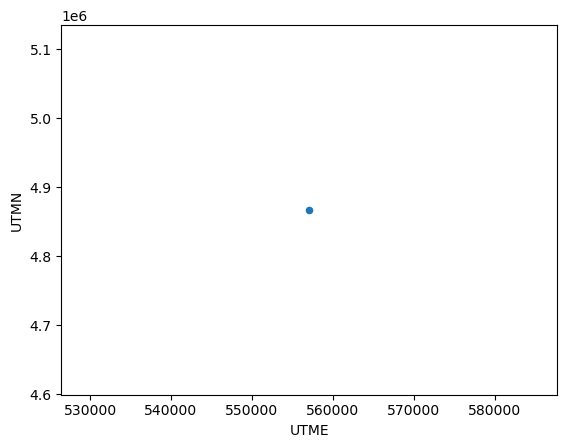

In [5]:
#Plot the location of the Galena well
ax = galena_df.plot.scatter(x='UTME', y='UTMN')

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

In [34]:
Lx = 10000 #Width of the domain, m
Ly = 10000 #Length of the domain, m
nlay = 1
nrow = 100
ncol = 100
delr = Lx / ncol * np.ones(ncol, dtype =float)
delc = Ly / nrow * np.ones(nrow, dtype = float)
top = 1240 #top row elevation in meters
top = top * np.ones((nrow, ncol), dtype=float) #create the top grid
botm = 1230 #bottom row elevation in meters
botm = botm * np.ones((nlay, nrow, ncol), dtype=float) #create the bottom grid


Text(0, 0.5, 'Northing (m)')

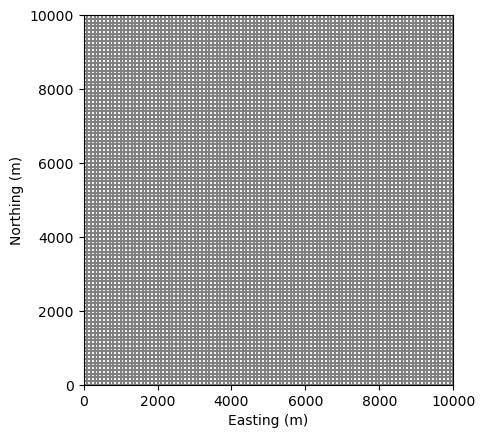

In [37]:
#Use the above parameters to create a modflow model grid
model_grid = flopy.discretization.StructuredGrid(
    delr = delr,
    delc = delc,
    top = top,
    botm = botm
)

#plot the grid produced by the above method
model_grid.plot()
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

grid_center_x = 557096.9423501687, grid_center_y = 4867264.089709508


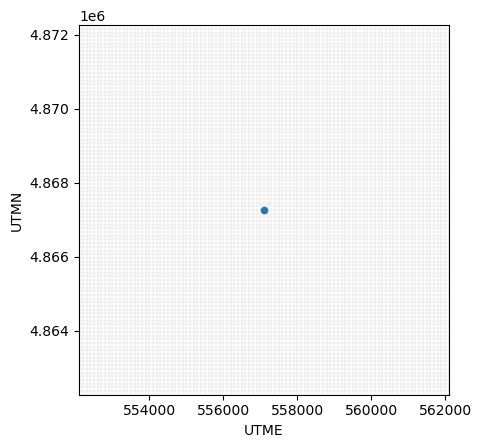

In [61]:
# Offset the grid onto the world coordinates available from the well data
grid_center_x , grid_center_y = galena_df['UTME'].iloc[0], galena_df['UTMN'].iloc[0] # Use the Easting and Northing as the central point on the grid
print(f'{grid_center_x = }, {grid_center_y = }') #print the central grid coordinates
grid_length_x = delr.sum()
grid_length_y = delc.sum()
xoff = grid_center_x - 0.5 * grid_length_x
yoff = grid_center_y - 0.5 * grid_length_y
model_grid.set_coord_info(xoff = xoff, yoff = yoff)
ax = galena_df.plot.scatter(x="UTME", y="UTMN") # plot the well locations
model_grid.plot(ax=ax, lw=0.1)

In [56]:
# Test that it is possible to find the row and column on the grid of each well

4862264.089709508